In [59]:
import time
from importlib.resources import files
import numpy as np
from Consensus import *
import Consensus
from collections import OrderedDict
from bitstring import Bits

In [60]:
INPUT_TREE_PATH = "../sample300/lowsample3.tre"
input_trees = TreeList_with_support.get(path = INPUT_TREE_PATH, schema = "newick")
majority = input_trees.majority_rule_consensus()

In [82]:
ASTRAL_INPUT_TREE_PATH = "../sample300/lowsample3.tre"
ASTRAL_TREE_PATH = "../sample300/low_astral3.tre"

In [83]:
astral_input_trees=TreeList_with_support.get(path = ASTRAL_INPUT_TREE_PATH, schema = "newick")
astral_tree = Tree_with_support.get(path = ASTRAL_TREE_PATH, schema = "newick",taxon_namespace = astral_input_trees.taxon_namespace)

In [84]:
astral_std = astral_tree.STD_greedy_pruning(astral_input_trees, normalized=True,time_flag =True)

computing transfer_support...
computing transfer_support for the other side...
current risk: 237979.8129130493
current risk: 237042.6771987636
current risk: 236110.14624638262
current risk: 235177.90457971598
current risk: 234249.27243685882
current risk: 233329.2100270464
current risk: 232412.72193180834
current risk: 231496.913598475
current risk: 230582.32867784007
current risk: 229675.92986831625
current risk: 228778.5382016496
current risk: 227886.12986831623
current risk: 226997.91637625278
current risk: 226109.7477254591
current risk: 225223.60764609402
current risk: 224340.60328101466
current risk: 223462.10209053848
current risk: 222590.3787139151
current risk: 221721.4668091532
current risk: 220854.78823772463
current risk: 219989.2310948675
current risk: 219123.84419010556
current risk: 218262.13149169288
current risk: 217410.58149169286
current risk: 216562.34815835953
current risk: 215719.16839645477
current risk: 214877.56680915318
current risk: 214043.02395201032
current

In [85]:
len(astral_std.bipartition_encoding)

398

In [86]:
len(astral_input_trees)

1000

In [87]:
#treelistのBipartitionListを作成する
BipartitionCountDict = OrderedDict()
BipartitionDict = OrderedDict()
BipartitionList = [];BipartitionBitsList = []
for tree in astral_input_trees:
    dict_keys = BipartitionCountDict.keys() # no duplicate keys in one tree
    tree.encode_bipartitions()
    for branch in tree.internal_edges(exclude_seed_edge=True):
        key = branch.bipartition.split_as_int()
        BipartitionDict.setdefault(key, branch.bipartition)
        if key in dict_keys:
            BipartitionCountDict[key] += 1
        else:
            BipartitionCountDict[key] = 1
for key, value in BipartitionCountDict.items():
    BipartitionList.append(key)
    bitstr = Bits(uint = key, length=astral_tree.n_taxa)
    BipartitionBitsList.append(bitstr)

In [88]:
Astral_BiparitionDict = OrderedDict()
Astral_BipartitionList = [];Astral_BipartitionBitsList = []

i = 0 #Listの何番目かを示す
for branch in astral_tree.internal_edges(exclude_seed_edge=True):
    key = branch.bipartition.split_as_int()
    Astral_BiparitionDict.setdefault(key,branch.bipartition)
    Astral_BipartitionList.append(key)
    bitstr = Bits(uint = key, length=astral_tree.n_taxa)
    Astral_BipartitionBitsList.append(bitstr)
    i +=1

In [89]:
#Astral_tree と Consensus treeの全てのDIST計算をする
Astral_DIST = np.zeros((len(Astral_BipartitionList), len(BipartitionList)))
for i in range(len(Astral_BipartitionList)):
    for j in range(len(BipartitionList)):
        Astral_DIST[i,j] = Consensus._greedy._MinHammingDist(Astral_BipartitionBitsList[i],BipartitionBitsList[j])

In [92]:
indices = []
for branch in astral_std.internal_edges(exclude_seed_edge=True):
    key = branch.bipartition.split_as_int()
    indices.append(Astral_BipartitionList.index(key))
    
refinfo = Consensus._consensus._create_refinfo([BipartitionDict[item] for item in BipartitionList], 300)
bipar_sizes = np.array([refinfo[item][1] for item in BipartitionList])

In [93]:
#argsortする
ORDER = np.zeros((len(Astral_BipartitionList)+1, len(BipartitionList))) # last dimension for external edge
for i in range(len(BipartitionList)):
    ORDER[:-1,i] = np.argsort(Astral_DIST[:,i])
ORDER[-1] = np.sum(Astral_DIST < bipar_sizes - 1, axis=0)

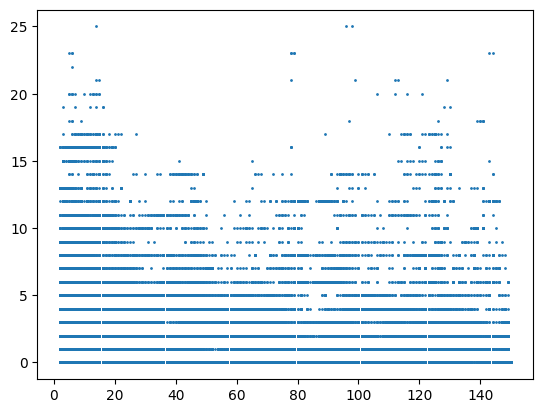

In [94]:
import matplotlib.pyplot as plt
x = bipar_sizes
y = np.min(ORDER[indices], axis=0)
plt.scatter(x,y, s=1)

<Axes: >

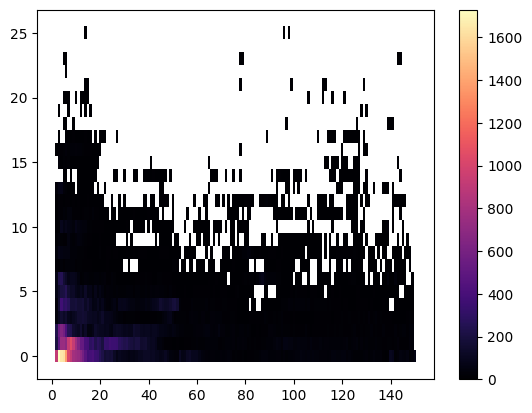

In [101]:
import seaborn as sns
from matplotlib.colors import LogNorm
sns.histplot(x=x, y=y, bins=(np.arange(x.min(), x.max() + 2) - 0.5, 
                             np.arange(y.min(), y.max() + 2) - 0.5), 
                        cbar=True, cmap="magma")